# Лабораторная работа 1. Бинарная классификация фрагментов речи с использованием мел-кепстральных коэффициентов

In [ ]:
!pip install librosa

In [712]:
import librosa
import librosa.display

from IPython.display import Audio

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка данных

In [713]:
import os

data_dir = '/content/drive/MyDrive/Распознавание и синтез речи/speech-classify-data'
files = os.listdir(data_dir)
data = []
for file in files:
    parts = file.split('_')
    data.append({
        "filename": f'{data_dir}/{file}',
        "emotion": parts[0],
        "gender": parts[1],
    })

data = pd.DataFrame(data)
data

filename    emotion  gender
0    /content/drive/MyDrive/Распознавание и синтез ...    painful  female
1    /content/drive/MyDrive/Распознавание и синтез ...      drunk  female
2    /content/drive/MyDrive/Распознавание и синтез ...      drunk    male
3    /content/drive/MyDrive/Распознавание и синтез ...      angry  female
4    /content/drive/MyDrive/Распознавание и синтез ...      angry  female
..                                                 ...        ...     ...
215  /content/drive/MyDrive/Распознавание и синтез ...    painful    male
216  /content/drive/MyDrive/Распознавание и синтез ...  stressful  female
217  /content/drive/MyDrive/Распознавание и синтез ...    painful    male
218  /content/drive/MyDrive/Распознавание и синтез ...    painful    male
219  /content/drive/MyDrive/Распознавание и синтез ...    painful  female

[220 rows x 3 columns]

## Проигрывание аудио

In [714]:
sample = data['filename'][20]
audio_data, sample_rate = librosa.load(sample)
print(sample_rate)
Audio(sample)

22050


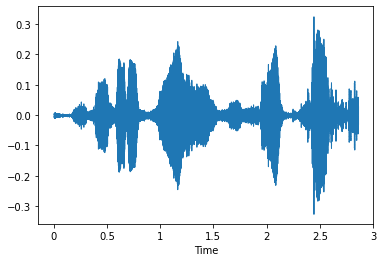

In [715]:
librosa.display.waveshow(y=audio_data, sr=sample_rate);

## Извлечение признаков из данных (мел-кепстральные коэффициенты)

In [716]:
N_MFCC = 14
sample_data = np.mean(librosa.feature.mfcc(y=audio_data, n_mfcc=N_MFCC, sr=sample_rate), axis=1)
sample_data

array([-355.7676   ,  141.96382  ,  -31.175102 ,   40.963623 ,
         -1.3910956,   -0.9444987,   13.644184 ,   -1.1468955,
          5.9084697,    5.7527156,    2.9793248,    7.5325556,
        -22.8373   ,    4.492103 ], dtype=float32)

## Задание

1. Сформируйте датасет (использовать мел-кепстральные коэффициенты для каждого аудиофайла).
2. Решите задачу бинарной классификации (определите пол говорящего) с помощью трех различных моделей (одна из них должна быть нейронной сетью с прямой связью). Оцените обученные модели (для этого придется предварительно разбить данные на обучающие и тестовые, а также использовать знакомые вам метрики классификации).

In [717]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm, tree


from scipy.special import softmax

In [718]:
# создаем датафрейм
def get_features_all(data, n_mfcc=14):
    columns = []
    for i in range(n_mfcc):
        columns.append(f'feature_{i}')
    columns.append('emotion')
    columns.append('gender')
    data_features = pd.DataFrame(columns=columns)

    for i in range(len(data)):
        next_file_name = data['filename'][i]
        audio_data, audio_rate = librosa.load(next_file_name)

        features = np.mean(librosa.feature.mfcc(y=audio_data, n_mfcc=n_mfcc, sr=sample_rate), axis=1)
        features = list(features) + list([data['emotion'][i], 
                                          1 if data['gender'][i]=='male' else 0]
                                         )
        
        data_features = data_features.append(dict(zip(columns, features)), ignore_index=True)

    return data_features

data_features = get_features_all(data, 20)
data_features.head()

feature_0   feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -356.718506  100.646553  -4.835288  18.846622 -11.717179  -0.553664   
1 -421.930115   80.886230  -4.347802  42.034229   2.950229  -5.734453   
2 -263.241913  148.025467 -13.700344  15.796622  22.800909  22.552769   
3 -270.467773   79.208130  16.888931  13.173677   0.955211  -2.642582   
4 -275.525391  127.323296 -29.462282  39.191338  19.264309  -6.125645   

   feature_6  feature_7  feature_8  feature_9  ...  feature_12  feature_13  \
0 -20.847881 -15.485029 -29.681032 -10.844356  ...   -3.887602   -7.237797   
1 -15.060660 -21.872725  11.830085 -22.811827  ...   -6.542002  -11.918012   
2 -33.228855   8.600425  -2.665508 -13.976529  ...   -3.001826   -1.967888   
3 -20.648046  -8.341570  -9.764419   7.504991  ...  -11.322871   -0.532901   
4  -5.992258 -10.608577  -3.145150  -3.675073  ...   -7.256543    8.345867   

   feature_14  feature_15  feature_16  feature_17  feature_18  feature_19  \
0   -6.673239  -10.189935  -14.110065   -6.981170  -11.177462   -5.686639   
1  -17.991833  -10.315934  -10.249162   -9.001829   -8.848784   -5.511591   
2   -0.045000    1.880726   -3.063359   -0.775780   -3.740422    1.080430   
3   -5.754652  -13.240907    1.674473   -5.266910  -11.568290    8.720476   
4  -14.096692   -9.489325    2.240640    2.225485   10.827064   17.465881   

   emotion  gender  
0  painful       0  
1    drunk       0  
2    drunk       1  
3    angry       0  
4    angry       0  

[5 rows x 22 columns]

In [719]:
# размар датасета маленький, поэтому просто продублируем его еще раз
data_features = data_features.append(data_features, ignore_index=True)

data_x = data_features.drop(['emotion', 'gender'], axis=1)
data_y = data_features['gender']

x_train, x_test, y_train, y_test = train_test_split(data_x,
                                                    data_y, 
                                                    test_size=0.2, random_state=1, stratify=data_y)

data_x=np.asarray(data_x).astype(np.float32)
data_y=np.asarray(data_y).astype(np.int32)


x_train=np.asarray(x_train).astype(np.float32)
x_test=np.asarray(x_test).astype(np.float32)
y_train=np.asarray(y_train).astype(np.int32)
y_test=np.asarray(y_test).astype(np.int32)

### SVM

In [720]:
svc = svm.SVC(kernel='linear')
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
print(y_pred)
print(y_test)

print(metrics.accuracy_score(y_pred, y_test))

[0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1
 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 1 1]
[0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0
 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 1]
0.8977272727272727


In [721]:
svc = svm.SVC(kernel='poly', degree=3)
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
print(y_pred)
print(y_test)

print(metrics.accuracy_score(y_pred, y_test))

[0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1
 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0
 0 1 1 1 0 1 0 0 0 0 1 0 1 1]
[0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0
 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 1]
0.75


### Decision Tree

In [722]:
dec_tree = tree.DecisionTreeClassifier(random_state=1)
dec_tree.fit(x_train, y_train)

y_pred = dec_tree.predict(x_test)
print(y_pred)
print(y_test)

print(metrics.accuracy_score(y_pred, y_test))

[0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0
 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 1]
[0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0
 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 1]
0.9318181818181818


### Keras


In [723]:
model = keras.Sequential([
    keras.layers.Input(data_x.shape[1]),

    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='sigmoid'),
    
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='sigmoid'),

    keras.layers.Dropout(0.1),
    keras.layers.Dense(2, activation='sigmoid'), # 2 - размер выходного слоя, т.к. 2 класса
])

model.build()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy',
              metrics=[
                  'accuracy',
              ])

model.summary()

Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_242 (Dropout)       (None, 20)                0         
                                                                 
 dense_619 (Dense)           (None, 64)                1344      
                                                                 
 dropout_243 (Dropout)       (None, 64)                0         
                                                                 
 dense_620 (Dense)           (None, 64)                4160      
                                                                 
 dropout_244 (Dropout)       (None, 64)                0         
                                                                 
 dense_621 (Dense)           (None, 2)                 130       
                                                                 
Total params: 5,634
Trainable params: 5,634
Non-trai

In [728]:
model.fit(x_train, y_train, epochs=3000)

Выходные данные были обрезаны до нескольких последних строк (5000).
11/11 [==============================] - 0s 4ms/step - loss: 0.4164 - accuracy: 0.8324
Epoch 502/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4303 - accuracy: 0.8239
Epoch 503/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4588 - accuracy: 0.8068
Epoch 504/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4230 - accuracy: 0.8352
Epoch 505/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4339 - accuracy: 0.8040
Epoch 506/3000
11/11 [==============================] - 0s 5ms/step - loss: 0.4394 - accuracy: 0.8295
Epoch 507/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.4385 - accuracy: 0.8239
Epoch 508/3000
11/11 [==============================] - 0s 7ms/step - loss: 0.4336 - accuracy: 0.8352
Epoch 509/3000
11/11 [==============================] - 0s 8ms/step - loss: 0.4033 - accuracy: 0.8466
Epoch 510/3000
11/11 [=======

In [731]:
y_pred = model.predict(x_test)
print(y_pred)

y_pred = np.argmax(y_pred, axis=1)

print(y_pred)
print(y_test)
print(list(zip(y_pred, y_test)))

print()
print(f'accuracy_score {metrics.accuracy_score(y_pred, y_test)}')

3/3 [==============================] - 0s 6ms/step
[[0.9653202  0.02948826]
 [0.23422778 0.61362875]
 [0.6531772  0.2509372 ]
 [0.23537877 0.6458955 ]
 [0.1580559  0.7334576 ]
 [0.23422778 0.61362875]
 [0.9122236  0.066856  ]
 [0.2883987  0.5793487 ]
 [0.08264516 0.8463952 ]
 [0.20601577 0.6865015 ]
 [0.9200837  0.06330615]
 [0.8477165  0.10695568]
 [0.76604456 0.17643628]
 [0.3390671  0.5256894 ]
 [0.5688996  0.37166005]
 [0.7436659  0.20950128]
 [0.9524399  0.04328817]
 [0.10857568 0.7878285 ]
 [0.87743443 0.10731044]
 [0.85225856 0.12527435]
 [0.04659858 0.89257956]
 [0.04620471 0.89668274]
 [0.03962315 0.90820354]
 [0.05028588 0.8868903 ]
 [0.89712363 0.08833035]
 [0.5837166  0.31051812]
 [0.8229256  0.1302056 ]
 [0.06214767 0.87073654]
 [0.06324113 0.8620585 ]
 [0.0774238  0.84409726]
 [0.25052226 0.6155788 ]
 [0.17793955 0.6967123 ]
 [0.05120741 0.8824335 ]
 [0.9293976  0.05776629]
 [0.91608846 0.07255945]
 [0.18007803 0.69912285]
 [0.5688996  0.37166005]
 [0.94071454 0.04895864]